In [2]:
import numpy as np
import torch
import open_clip
import csv
from tqdm import tqdm
import pandas
import matplotlib.pyplot as plt

/home/martin/Documents/MScProject/project_local/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
testsets = {
    "Progan" : ["progan_lsun"],
    "Biggan" : ["biggan_256","biggan_512"],
    "Gaugan" : ["gaugan"],
    "Stargan" : ["stargan"],
    "EG3D" : ["eg3d"],
    "Stylegan 2": ["stylegan2_afhqv2_512x512",
                   "stylegan2_ffhq_256x256",
                   "stylegan2_ffhq_1024x1024",
                   "stylegan2_lsundog_256x256",
                   "whichfaceisreal"],
    "Stylegan 3" : ["stylegan3_r_afhqv2_512x512",
                    "stylegan3_r_ffhqu_256x256",
                    "stylegan3_r_ffhqu_1024x1024",
                    "stylegan3_t_afhqv2_512x512",
                    "stylegan3_t_ffhqu_256x256",
                    "stylegan3_t_ffhqu_1024x1024"],
    "Taming Trans." : ["taming-transformers_class2image_ImageNet",
                             "taming-transformers_noise2image_FFHQ",
                             "taming-transformers_segm2image_valid"],
    "Dall-E Mini" : ["dalle-mini_valid"],
    "Dall-E 2" : ["dalle_2"],
    "Glide" : ["glide_text2img_valid"],
    "Guided Dif." : ["guided-diffusion_class2image_ImageNet",  
                "guided-diffusion_noise2image_LSUNbedrooms",
                "guided-diffusion_noise2image_LSUNcats",
                "guided-diffusion_noise2image_LSUNhorses"],
    "Latent Dif." : ["latent-diffusion_class2image_ImageNet",
                          "latent-diffusion_noise2image_FFHQ",
                          "latent-diffusion_noise2image_LSUNbedrooms",
                          "latent-diffusion_noise2image_LSUNchurches",
                          "latent-diffusion_text2img_valid"],
    "Stable Diff." : ["stable_diffusion_256"],
    "Stable Diff. v2" : ["stable_diffusion_512_50steps",
                             "stable_diffusion_512_100steps",
                             "stable_diffusion_512_200steps"],
    "DeepFakes" : ["deepfake"],
    "Pristine" : ["real_coco_valid", 
                  "real_imagenet_val", 
                  "real_ucid",
                  "ffhq",
                  "celebA",
                  ],
}

In [6]:
progan_openai_25 = pandas.read_csv("data/ablation/progan_openai_25.csv", header=0, index_col=0)
progan_openai_50 = pandas.read_csv("data/ablation/progan_openai_50.csv", header=0, index_col=0)
progan_openai_75 = pandas.read_csv("data/ablation/progan_openai_75.csv", header=0, index_col=0)
progan_openai_100 = pandas.read_csv("data/progan-trained/vitL14_progan_openai_720k_net_accuracies.csv", header=0, index_col=0)
progan_stable_laion_25 = pandas.read_csv("data/ablation/progan_stable_laion_25.csv", header=0, index_col=0)
progan_stable_laion_50 = pandas.read_csv("data/ablation/progan_stable_laion_50.csv", header=0, index_col=0)
progan_stable_laion_75 = pandas.read_csv("data/ablation/progan_stable_laion_75.csv", header=0, index_col=0)
progan_stable_laion_100 = pandas.read_csv("data/fuse/progan+stable_vitH14_200k_laion_net_accuracy.csv", header=0, index_col=0)

models = [
        "Progan 100%", "Progan 75%", "Progan 50%", "Progan 25%",
        "FUSED 100%", "FUSED 75%", "FUSED 50%", "FUSED 25%"
        ]
colors = {
    "Progan 100%": "red",
    "Progan 75%": "coral",
    "Progan 50%": "orange",
    "Progan 25%": "gold",
    "FUSED 100%": "red",
    "FUSED 75%": "coral",
    "FUSED 50%": "orange",
    "FUSED 25%": "gold"
}

allsubmodels = []
for key in testsets:
    allsubmodels = allsubmodels + testsets[key]
tab_metrics = pandas.DataFrame(index=list(allsubmodels), columns = models)

for key in allsubmodels:
    tab_metrics.loc[key, "Progan 25%"] = progan_openai_25.loc[key + ".pt", "0.30"]
    tab_metrics.loc[key, "Progan 50%"] = progan_openai_50.loc[key + ".pt", "0.30"]
    tab_metrics.loc[key, "Progan 75%"] = progan_openai_75.loc[key + ".pt", "0.30"]
    tab_metrics.loc[key, "Progan 100%"] = progan_openai_100.loc[key + ".pt", "0.30"]
    tab_metrics.loc[key, "FUSED 25%"] = progan_stable_laion_25.loc[key + ".pt", "0.90"]
    tab_metrics.loc[key, "FUSED 50%"] = progan_stable_laion_50.loc[key + ".pt", "0.90"]
    tab_metrics.loc[key, "FUSED 75%"] = progan_stable_laion_75.loc[key + ".pt", "0.90"]
    tab_metrics.loc[key, "FUSED 100%"] = progan_stable_laion_100.loc[key + ".pt", "0.90"]

def plot_raw_accuracy(sets, models, width=0.30, multiplier=-1):
    plot_sets = sets
    plot_models = models

    x = np.arange(len(plot_sets))

    fig, ax = plt.subplots(layout='constrained')
    fig.set_size_inches(18.5, 3.0)

    for model in plot_models:
        measurement = []
        for set in plot_sets:
            subsets = testsets[set]
            m = np.mean([tab_metrics.loc[subset, model] for subset in subsets])
            measurement.append(m)
        measurement = tuple([m * 100 for m in measurement])
        offset = width * multiplier
        rects = ax.bar(x+offset, measurement, width, label=model, color=colors[model])
        multiplier += 1

    ax.set_ylabel("Accuracy")
    ax.set_xticks(x+width, plot_sets)
    ax.legend(loc='upper center', ncols=len(models))
    ax.set_ylim(0,115)
    ax.axhline(y = 100, color = 'black', linestyle = '-')

    plt.show()

def plot_mean_accuracy(sets, models, width=0.30, multiplier=-1):
    plot_sets = sets
    plot_models = models

    x = np.arange(len(plot_sets))

    fig, ax = plt.subplots(layout='constrained')
    fig.set_size_inches(18.5, 3.0)

    for model in plot_models:
        measurement = []
        for set in plot_sets:
            subsets = testsets[set]
            m = np.mean([tab_metrics.loc[subset, model] for subset in subsets])
            measurement.append(m)
        pristine_mean = np.mean([tab_metrics.loc[subset, model] for subset in testsets["Pristine"]])
        measurement = [(m+pristine_mean)/ 2 * 100 for m in measurement]
        GAN_accuracy = np.mean(measurement[0:7])
        VQGAN_accuracy = np.mean(measurement[7:9])
        DM_accuracy = np.mean(measurement[7:-2])
        mean_accuracy = np.mean(measurement[:-1])
        print(f"{model} : GAN({GAN_accuracy}) VQGAN({VQGAN_accuracy} DM({DM_accuracy}) MEAN({mean_accuracy})")
        measurement = tuple(measurement)
        offset = width * multiplier
        rects = ax.bar(x+offset, measurement, width, label=model, color = colors[model])
        multiplier += 1

    ax.set_ylabel("Accuracy")
    ax.set_xticks(x+width, plot_sets)
    ax.set_ylim(0,115)
    ax.legend(loc='upper center', ncols=len(models))
    ax.axhline(y = 50, color = 'r', linestyle = '--')
    ax.axhline(y = 100, color = 'black', linestyle = '-')

    plt.show()
    

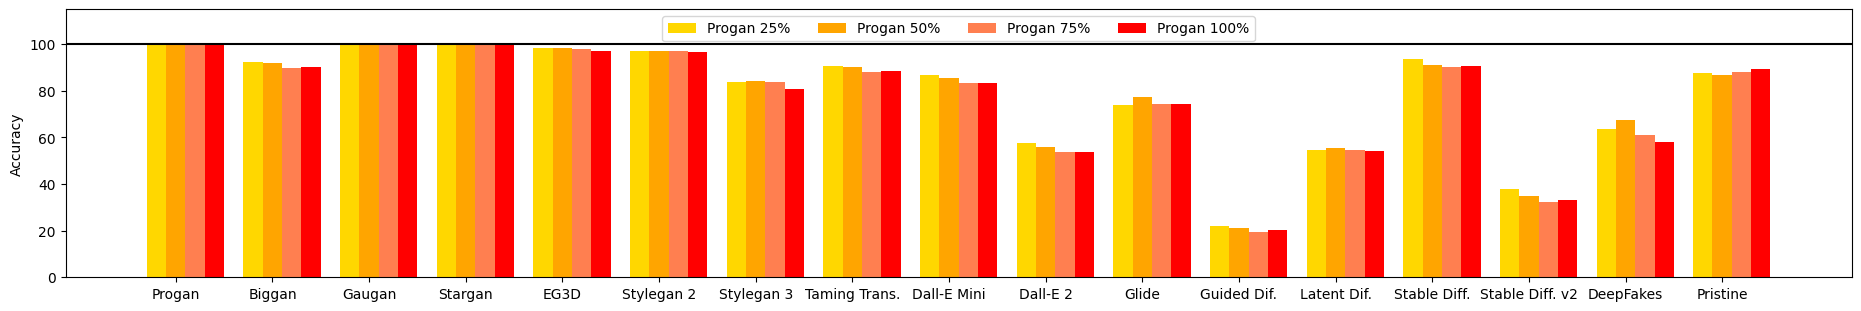

Progan 25% : GAN(91.8370423062202) VQGAN(88.26393070152415 DM(78.13619260628604) MEAN(83.50843833927121)
Progan 50% : GAN(91.49654147508086) VQGAN(87.43380096550518 DM(77.5580866797909) MEAN(82.95274653664049)
Progan 75% : GAN(91.74981318389436) VQGAN(86.88045304341259 DM(77.13045304341259) MEAN(82.82393222008186)
Progan 100% : GAN(92.16159178424802) VQGAN(87.65923504652176 DM(77.88477076080747) MEAN(83.43447374634957)


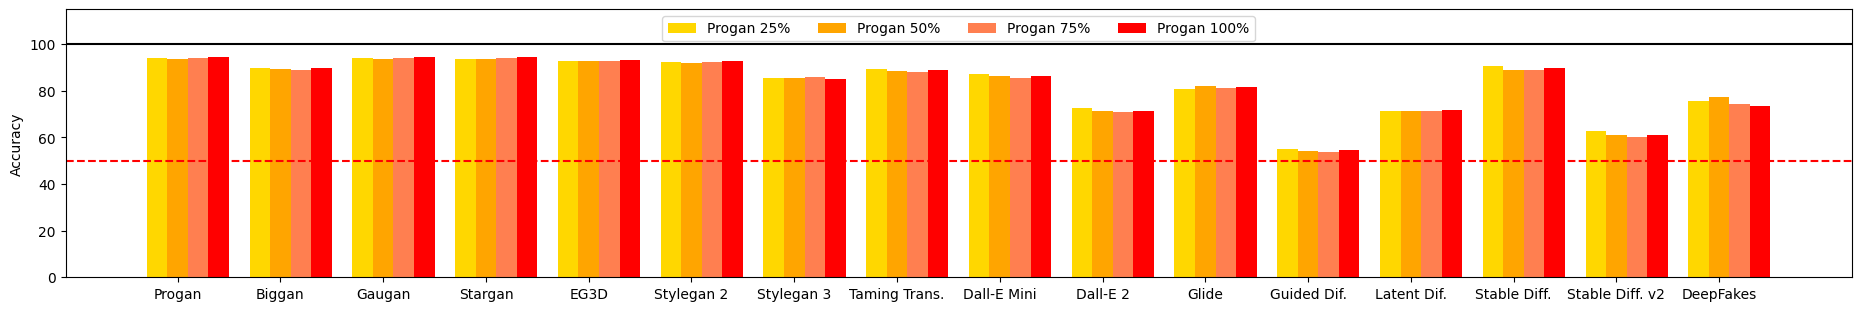

In [7]:
plot_sets = list(testsets.keys())
plot_models = ["Progan 25%", "Progan 50%", "Progan 75%", "Progan 100%", ]

plot_raw_accuracy(plot_sets, plot_models, multiplier=0, width=0.20)

plot_sets = list(testsets.keys())[:-1]
plot_mean_accuracy(plot_sets, plot_models, multiplier=0, width=0.20)

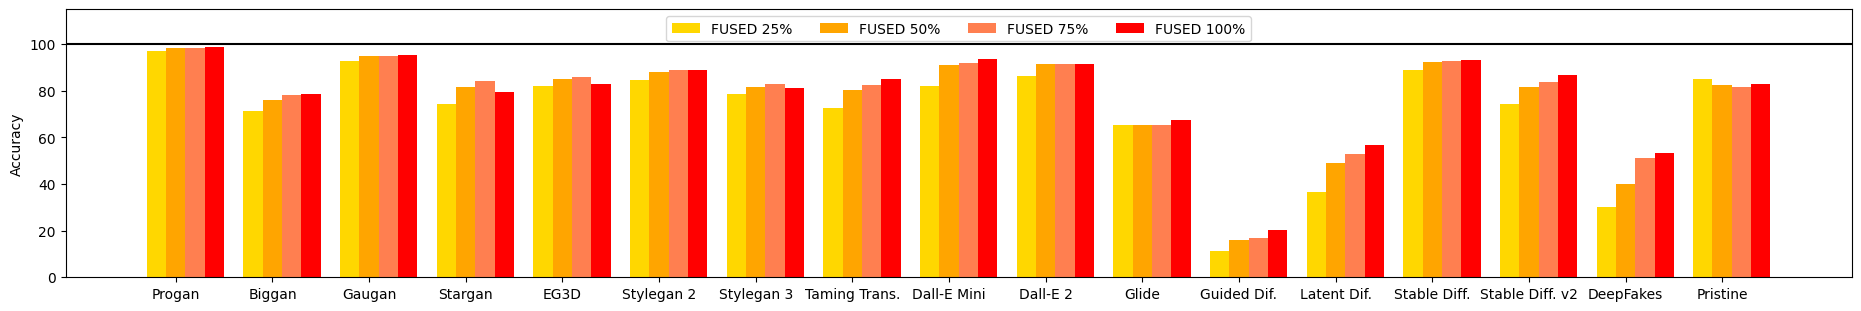

FUSED 25% : GAN(84.00524461056925) VQGAN(81.17074345767801 DM(74.12562441005898) MEAN(79.10689955124947)
FUSED 50% : GAN(84.65518496334406) VQGAN(84.26866994483788 DM(76.08122946864741) MEAN(80.49268250902968)
FUSED 75% : GAN(84.70580728346532) VQGAN(84.53042352715968 DM(76.16107828906445) MEAN(80.58824150232455)
FUSED 100% : GAN(84.66135297203414) VQGAN(86.1342937215992 DM(77.70000800731349) MEAN(81.42147692735774)


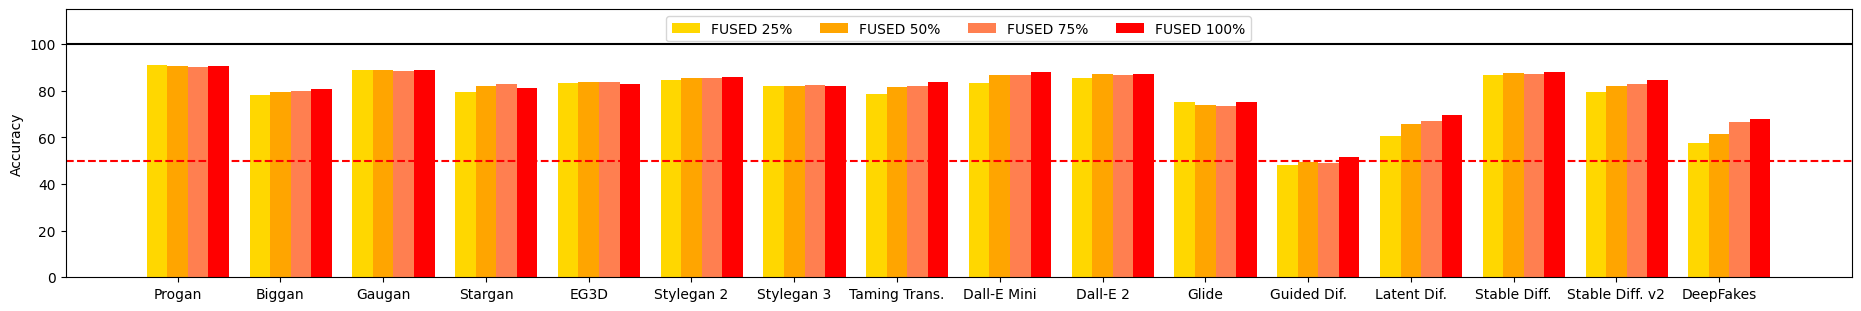

In [8]:
plot_sets = list(testsets.keys())
plot_models = ["FUSED 25%", "FUSED 50%", "FUSED 75%", "FUSED 100%", ]

plot_raw_accuracy(plot_sets, plot_models, multiplier=0, width=0.20)

plot_sets = list(testsets.keys())[:-1]
plot_mean_accuracy(plot_sets, plot_models, multiplier=0, width=0.20)